In [14]:
import os
import cmdstanpy as stan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import arviz as az

In [15]:
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

# Toy model

## Data

In [67]:
# Seed
np.random.seed(123)


sg_u = 3
sg_w = 5

sg_theta = 0.5

mu = 6

# Number of users
n_u = 20
# Number of words
n_w = 100
# Number of obs
n_o = 100

# Generate data
U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

theta = np.zeros(shape=(n_w, n_u, n_o))

for w in range(n_w):
    for u in range(n_u):
        theta[w,u, :] = np.random.normal(mu + U[u] + W[w], sg_theta, size=n_o)
        
data = {'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'theta': theta}

In [68]:
np.mean(theta)

6.327207267491035

## Define the model

In [69]:
%%stan -f model.stan -v model
data {
  int<lower=0> n_u;  // Number of users    
  int<lower=0> n_w;  // Number of words
  int<lower=0> n_o;  // Number of observations
  real theta[n_w, n_u, n_o];
}
parameters {
  real<lower=0> sg_u;
  real<lower=0> sg_w;
  real<lower=0> sg_theta;
  real mu;

  real W[n_w];
  real U[n_u];
}
model {
  sg_w ~ normal(0, 1);
  sg_u ~ normal(0, 1);
  sg_theta ~ normal(0, 1);
  mu ~ normal(0, 1);
  
  U[1:n_u] ~ normal(0, sg_u);
  W[1:n_w] ~ normal(0, sg_w);

  for (u in 1:n_u) {
      for (w in 1:n_w) {
          theta[w,u] ~ normal(mu + U[u] + W[w], sg_theta);
      }
  }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [model.stan]
model.model_name -> Name of stan model [model_model]
model.model_code -> Model code [data {   int<lower=0 ....]


In [70]:
model.model_file

'model.stan'

In [71]:
m = CmdStanModel(stan_file=model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model


## Sampling

In [72]:
trace = m.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
sm = trace.summary()
sm[sm.index.isin(("mu", "sg_u", "sg_w", "sg_theta"))]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
sg_u,3.5,0.043000,0.4300,2.9,3.5,4.3,99.0,0.0380,1.1
sg_w,5.1,0.009500,0.3000,4.7,5.1,5.6,1000.0,0.3800,1.0
sg_theta,0.5,0.000016,0.0008,0.5,0.5,0.5,2600.0,0.9900,1.0
mu,3.6,0.310000,0.7500,2.2,3.7,4.7,6.0,0.0023,1.6


array([[<AxesSubplot:title={'center':'sg_u'}>,
        <AxesSubplot:title={'center':'sg_u'}>],
       [<AxesSubplot:title={'center':'sg_w'}>,
        <AxesSubplot:title={'center':'sg_w'}>],
       [<AxesSubplot:title={'center':'sg_theta'}>,
        <AxesSubplot:title={'center':'sg_theta'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={'center':'W'}>],
       [<AxesSubplot:title={'center':'U'}>,
        <AxesSubplot:title={'center':'U'}>]], dtype=object)

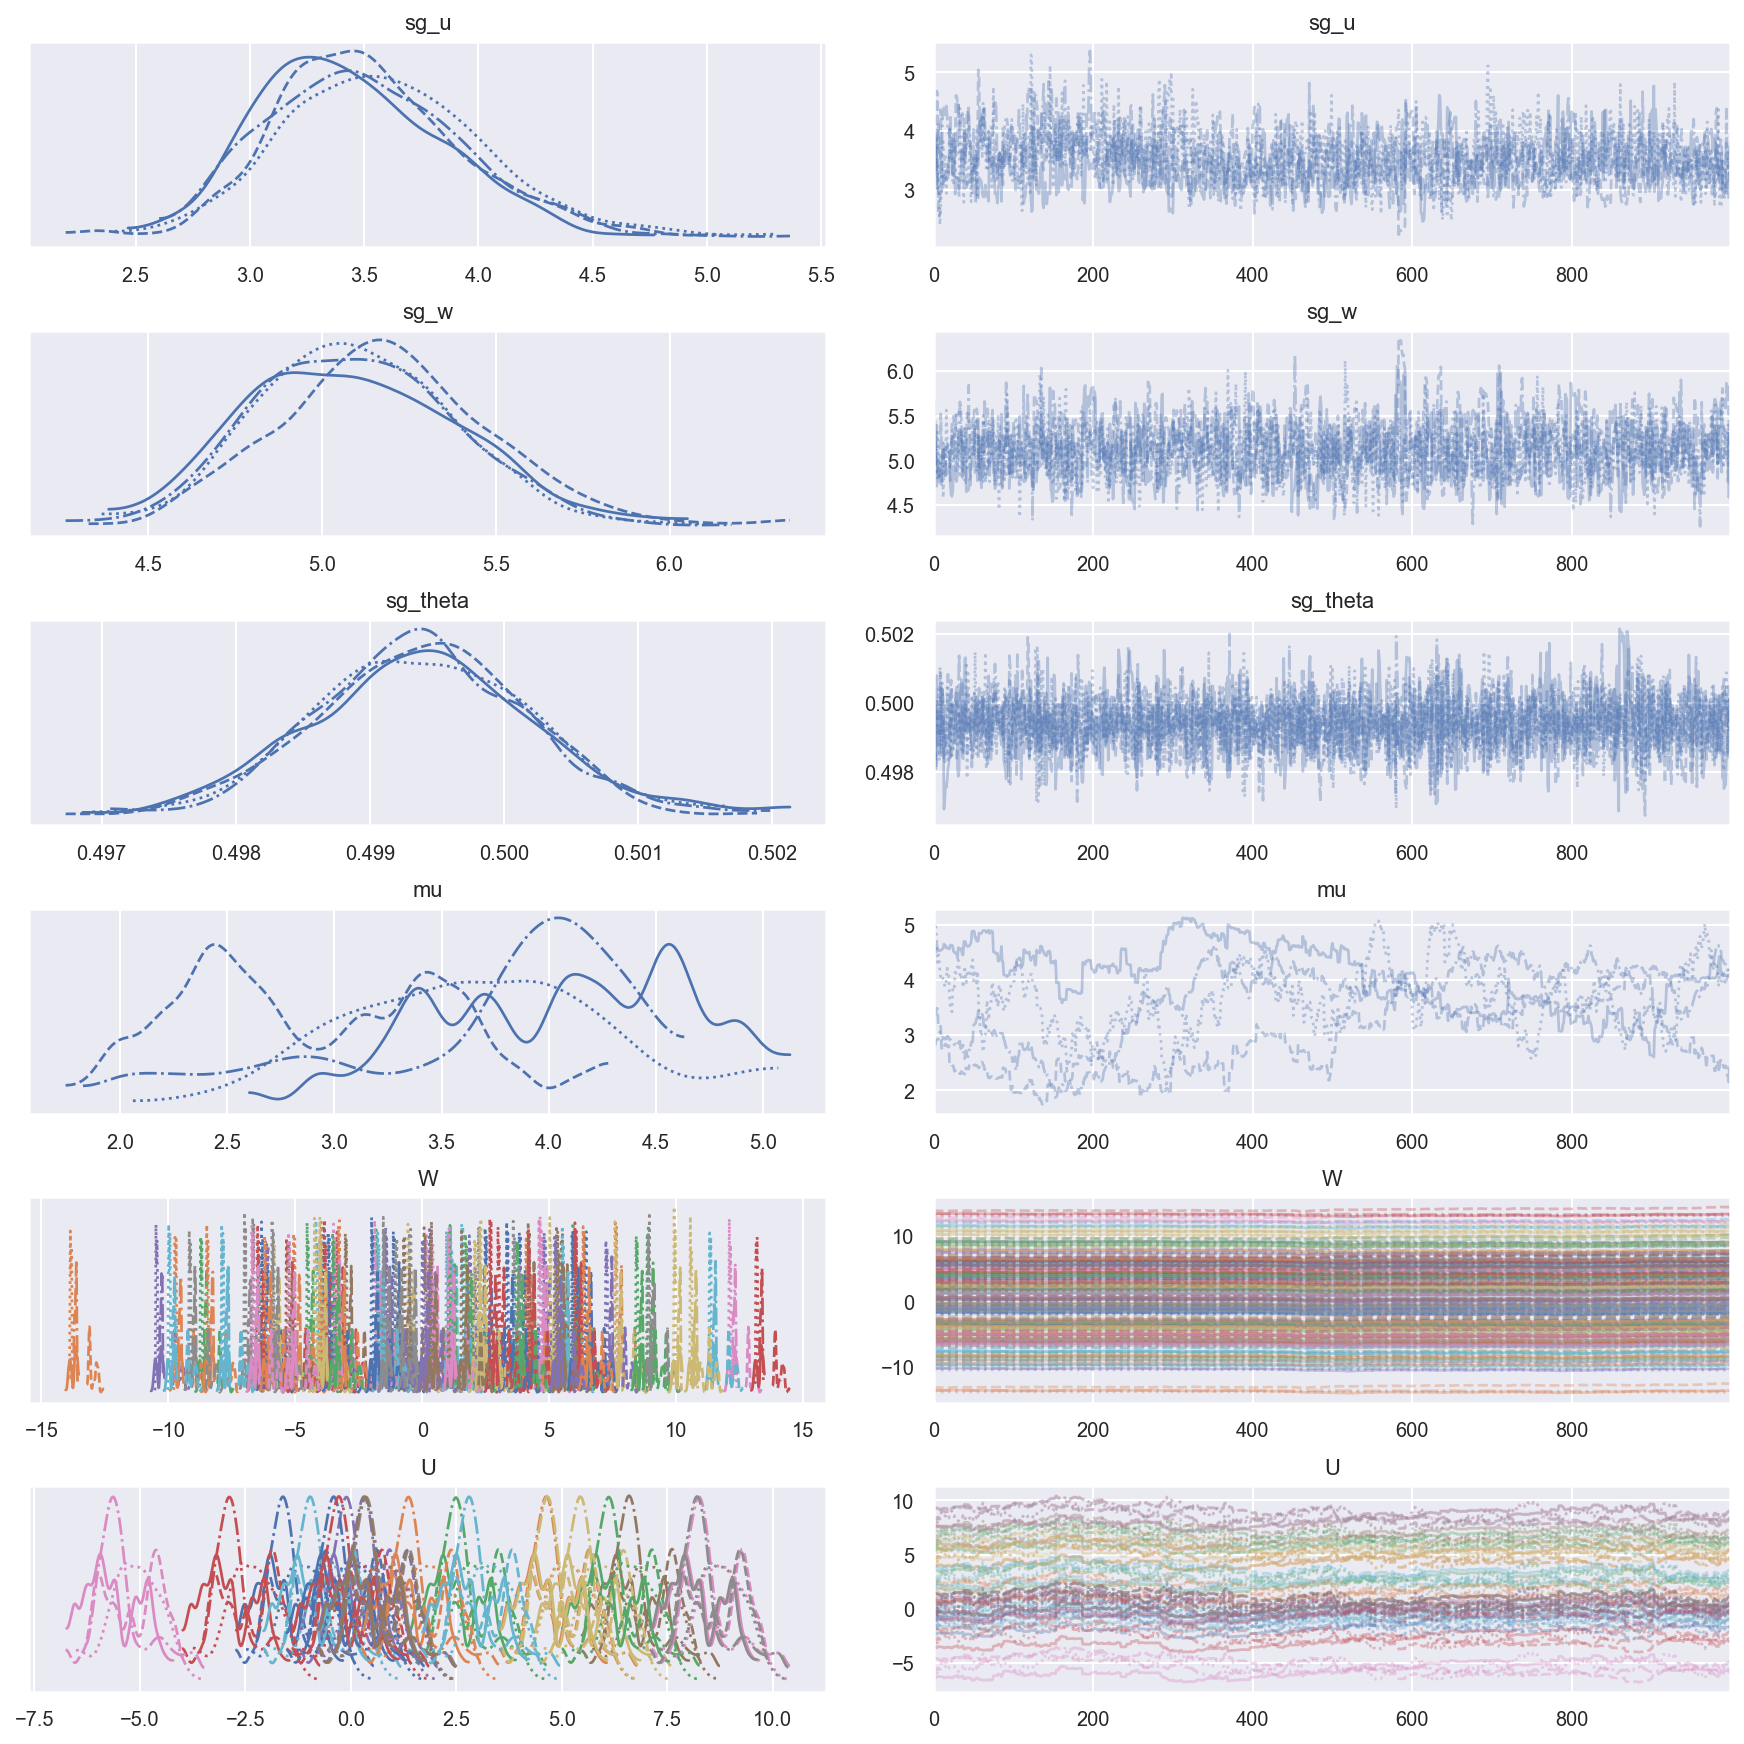

In [74]:
az.plot_trace(trace)

In [227]:
%%stan -f model2.stan -v model2
data {
  int<lower=0> n_u;  // Number of users    
  int<lower=0> n_w;  // Number of words
  int<lower=0> n_o;  // Number of observations
  int<lower=0> n;
  real x[n_w, n_u, n_o];
  int y[n_w, n_u, n_o];
}
transformed data {
  vector[n] x_arr;
  int y_arr[n];
  
  x_arr = to_vector(to_array_1d(x));
  y_arr = to_array_1d(y);
}
parameters {
  real<lower=0> sg_u;
  real<lower=0> sg_w;
  real<lower=0> sg_theta;
  real mu;

  real W[n_w];
  real U[n_u];
  real theta_wu[n_w, n_u];
}
model {
  real theta[n_w, n_u, n_o];
  vector[n] theta_arr;
  vector[n] rate;
  vector[n] exponent;
  vector[n] p;
  // vector[n] p_bn;
  
  sg_w ~ inv_gamma(1, 1);
  sg_u ~ inv_gamma(1, 1);
  sg_theta ~ inv_gamma(1, 1);
  mu ~ normal(0, 10);
  
  U ~ normal(0, sg_u);
  W ~ normal(0, sg_w);

  for (u in 1:n_u) {
    for (w in 1:n_w) {
      theta_wu[w, u] ~ normal(mu + U[u] + W[w], sg_theta);
      theta[w, u] = to_array_1d(rep_vector(theta_wu[w, u], n_o)); 
    }
  }
  
  theta_arr = to_vector(to_array_1d(theta));
  rate = exp(theta_arr);
  exponent = -rate .* x_arr;
  p = exp(exponent);
  // p_bn = pow(p, y_arr) .* pow(1-p, 1-y_arr); 
  y_arr ~ bernoulli(p);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model2 object.
Type model2 in a cell to see a nicely formatted code output in a notebook
     ^^^^^^
Access model compile output properties
model2.model_file -> Name of stan_file [model2.stan]
model2.model_name -> Name of stan model [model2_model]
model2.model_code -> Model code [data {   int<lower=0 ....]


In [228]:
m2 = CmdStanModel(stan_file=model2.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2


[]

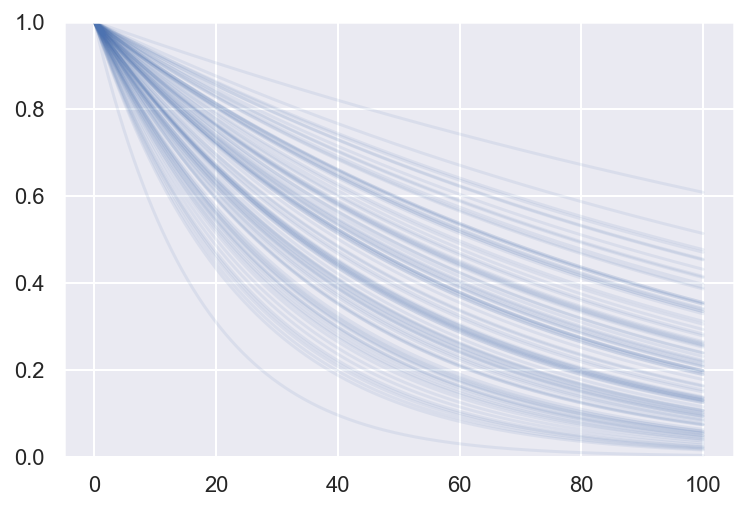

In [190]:
theta = np.random.normal(-4, 0.5, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

[]

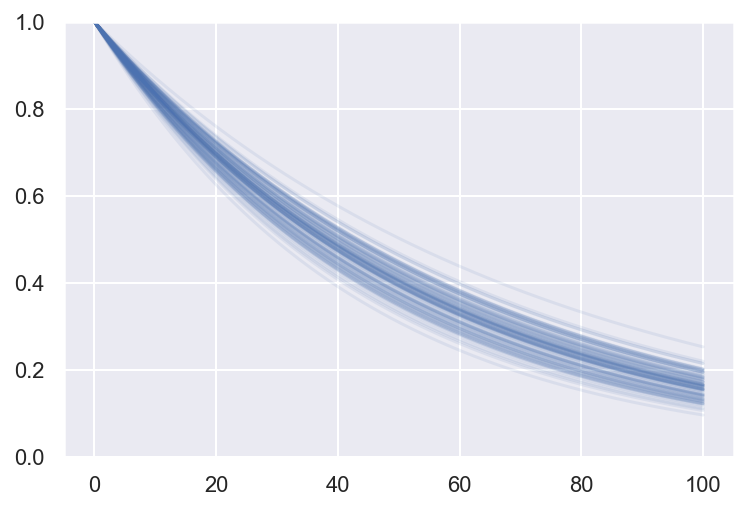

In [191]:
theta = np.random.normal(-4, 0.1, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

In [229]:
# Seed
np.random.seed(123)


sg_u = 0.1
sg_w = 0.5

sg_theta = 0.001

mu = -4

# Number of users
n_u = 20
# Number of words
n_w = 10
# Number of obs
n_o = 10

# Generate data
U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

shape = (n_w, n_u, n_o)

x = np.random.uniform(0, 100, size=shape)
rd = np.random.random(size=shape)

y = np.zeros(shape=shape, dtype=int)
theta = np.zeros(shape=shape)

for w in range(n_w):
    for u in range(n_u):
        theta[w,u, :] = np.random.normal(mu + U[u] + W[w], sg_theta)

rate = np.exp(theta)
exponent = - rate * x
p = np.exp(exponent)
y[:] = p > rd
        
data = {'n': n_w*n_o*n_u, 'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'x': x, 'y': y}

In [230]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.47112128756205 0.9999262789013634 0.010665830904122677
0.4755 0 1


In [234]:
trace = m2.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sg_w'}>,
        <AxesSubplot:title={'center':'sg_w'}>],
       [<AxesSubplot:title={'center':'sg_u'}>,
        <AxesSubplot:title={'center':'sg_u'}>]], dtype=object)

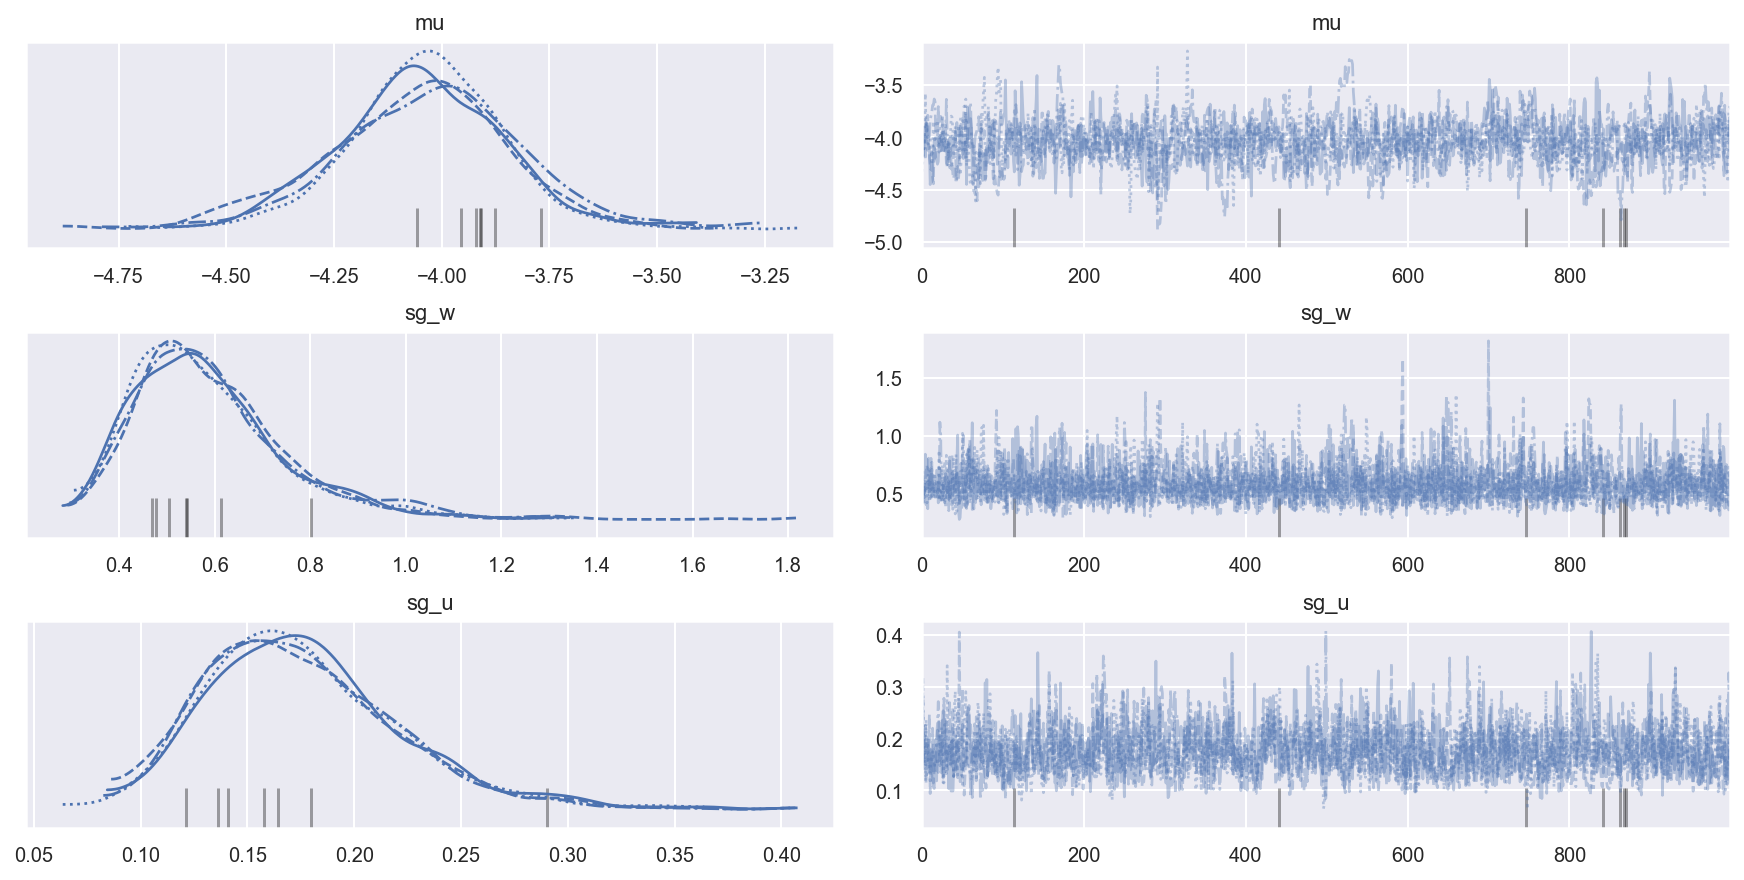

In [235]:
az.plot_trace(trace, var_names=['mu', 'sg_w', 'sg_u'])

## MLE

In [231]:
%%time
mp = m2.optimize(data=data, algorithm='BFGS', seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 6.86 ms, sys: 9.94 ms, total: 16.8 ms
Wall time: 1.37 s


In [232]:
mp.optimized_params_dict

OrderedDict([('lp__', -111.635),
             ('sg_u', 0.050032),
             ('sg_w', 0.466964),
             ('sg_theta', 0.00495097),
             ('mu', -4.03594),
             ('W[1]', 0.393598),
             ('W[2]', 0.573649),
             ('W[3]', -0.339012),
             ('W[4]', 0.551151),
             ('W[5]', -0.413458),
             ('W[6]', -0.193962),
             ('W[7]', 0.550564),
             ('W[8]', -0.705156),
             ('W[9]', 0.0585376),
             ('W[10]', -0.484408),
             ('U[1]', -0.00786478),
             ('U[2]', -0.0108683),
             ('U[3]', 0.00208648),
             ('U[4]', -0.00544469),
             ('U[5]', -0.00918648),
             ('U[6]', 0.0152968),
             ('U[7]', -0.0253912),
             ('U[8]', 0.00226536),
             ('U[9]', 0.0117758),
             ('U[10]', -0.0157935),
             ('U[11]', -0.00768799),
             ('U[12]', 0.00995526),
             ('U[13]', 0.0218971),
             ('U[14]', -0.0216086)

## VI

In [238]:
m2.name

'model2'

In [241]:
m2.variational(data=data, seed=12)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RuntimeError: Error during variational inference.
RunSet: chains=1
 cmd:
	['/Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2', 'random', 'seed=12', 'data', 'file=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpydu0itt1/311yss1x.json', 'output', 'file=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpydu0itt1/model2-202102241404-1-ttt9khap.csv', 'method=variational', 'adapt', 'engaged=1']
 retcodes=[70]
 csv_files:
	/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpydu0itt1/model2-202102241404-1-ttt9khap.csv
 console_msgs:
	/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpydu0itt1/model2-202102241404-1-ttt9khap-stdout.txt

### Scaling

In [183]:
# Seed
np.random.seed(123)


sg_u = 0.1
sg_w = 0.5

sg_theta = 0.001

mu = -4

# Number of users
n_u = 30
# Number of words
n_w = 30
# Number of obs
n_o = 100

# Generate data
U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

shape = (n_w, n_u, n_o)

x = np.random.uniform(0, 100, size=shape)
rd = np.random.random(size=shape)

y = np.zeros(shape=shape, dtype=int)
theta = np.zeros(shape=shape)

for w in range(n_w):
    for u in range(n_u):
        theta[w,u, :] = np.random.normal(mu + U[u] + W[w], sg_theta)

rate = np.exp(theta)
exponent = - rate * x
p = np.exp(exponent)
y[:] = p > rd
        
data = {'n': n_w*n_o*n_u, 'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'x': x, 'y': y}

In [184]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.4388316861285626 0.9999971784210457 0.0005632250371915136
0.4391 0 1


In [185]:
trace = m2.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sg_w'}>,
        <AxesSubplot:title={'center':'sg_w'}>],
       [<AxesSubplot:title={'center':'sg_u'}>,
        <AxesSubplot:title={'center':'sg_u'}>]], dtype=object)

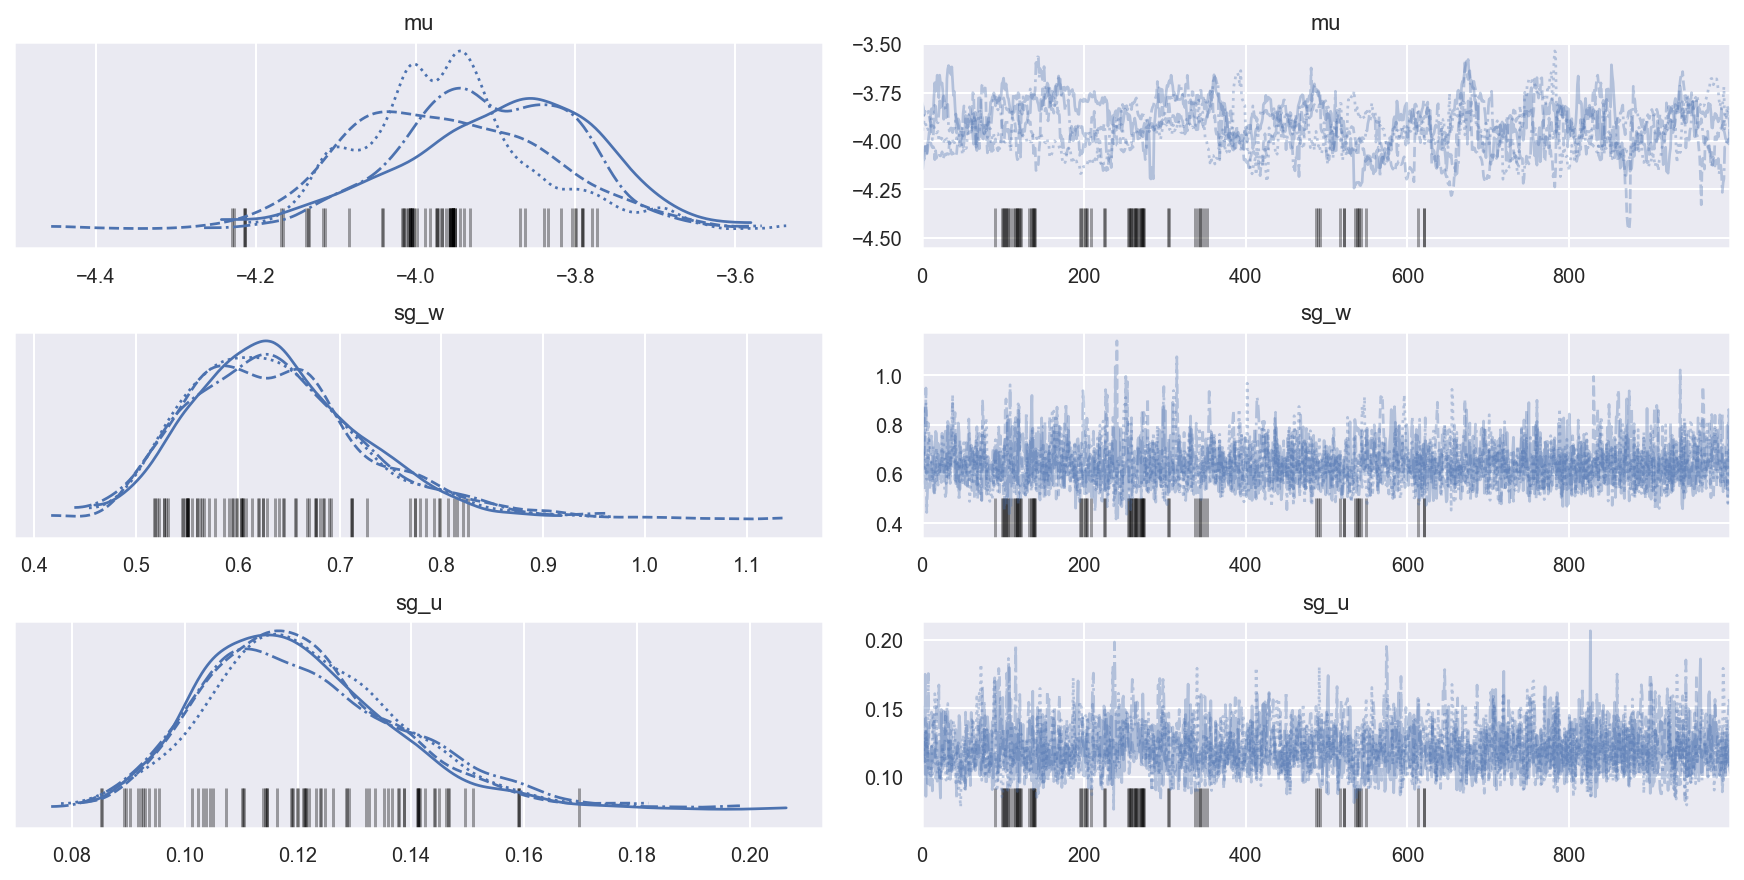

In [186]:
az.plot_trace(trace, var_names=['mu', 'sg_w', 'sg_u'])